## Setting Up

In [ ]:
!pip install --upgrade langchain

In [ ]:
!pip install langchain-google-genai

In [3]:
from google.colab import userdata

In [4]:
import os
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

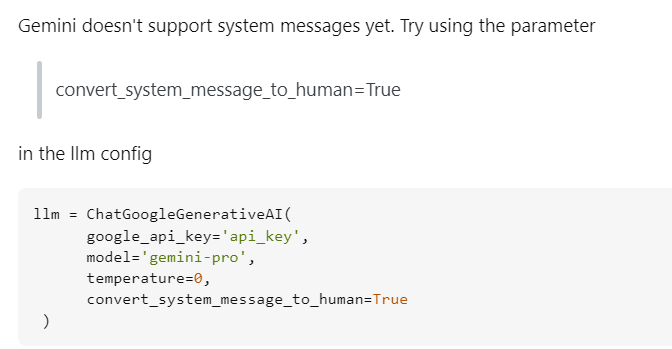

In [6]:
llm = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=GOOGLE_API_KEY, convert_system_message_to_human=True) #, temperature=0.1

## Image Captioning Tool

In [48]:
# @title
# Use a pipeline as a high-level helper
from transformers import pipeline
image_to_text = pipeline("image-to-text", model="Salesforce/blip-image-captioning-large")

In [88]:
from langchain.agents import initialize_agent
from langchain.tools import BaseTool
from langchain.chains.conversation.memory import ConversationBufferWindowMemory

In [89]:
class ImageCaptionTool(BaseTool):
    name = "Image captioner"
    description = "Use this tool when given the URL of image that you would like to be captioned. " \
                  "It will return a caption describing the scene in the image."
                  #It will provide a concise and descriptive caption for the given image,according to given context, describing the main objects, people, scenes, and actions present in the image, while keeping the caption coherent and natural-sounding."
                  #detailed and specific description of the image,focusing on key elements such as objects, actions, scenes"

    def _run(self, url):
        #image_to_text = pipeline("image-to-text", model="Salesforce/blip-image-captioning-large")
        caption = image_to_text(url, max_new_tokens=200)
        return caption[0]['generated_text']


In [90]:
tools = [ImageCaptionTool()]

In [91]:
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=2,
    return_messages=True
)

In [92]:
agent = initialize_agent(
    agent="chat-conversational-react-description",
    tools=tools,
    llm=llm,
    max_iterations=5,
    verbose=False,
    memory=conversational_memory,
    early_stopping_method='generate'
)

In [93]:
new_prompt = agent.agent.create_prompt(
    #system_message=sys_msg,
    tools=tools
)
agent.agent.llm_chain.prompt = new_prompt

# update the agent tools
agent.tools = tools

In [97]:
# @title
url = 'https://i0.wp.com/www.mcaleerlaw.net/wp-content/uploads/2021/04/thief-4173477_1280.jpg?resize=525%2C338&quality=89&ssl=1'

In [98]:
# @title
response= agent(f"The given image is related to scenario of crime, theft related incident. Describe this image in a complete, detailed sentences according to this scenario?\n{url}")

In [99]:
# @title
response['output']

'The image shows a cartoon thief with a sack of money and a hammer in his hand, looking out the window.'

In [ ]:
# @title
response = agent.invoke(f'{user_question}-{url}')


In [ ]:
# @title
#user_question = 'Describe this image in a complete, detailed sentence focusing on the main subject and action. Point out any notable objects, people, animals or scenery. Use descriptive language and explain the relationships between elements in a natural way.'

In [ ]:
# @title
#user_question = 'Please describe what is happening in this image according to given context. The context is crime, theft, robbery. Please do not use may be,might be or possibility'

## testing on images in URL list to calc BLEU score- bulk images

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel('/content/REPEATED_crime_theft_robbery_dataset_captioned.xlsx')

In [ ]:
df.head()

In [ ]:
df_upd = df['URL']

In [ ]:
df_upd.head()

In [ ]:
df_upd.count()

69

In [ ]:
url_lst=df_upd.to_list()

In [ ]:
len(url_lst)

69

In [ ]:
url_lst = url_lst[:5]

In [ ]:
url_lst

['https://houstoncriminalfirm.com/wp-content/uploads/2019/06/Canva-_-Theft-900x600.jpg',
 'https://www.careylawoffice.com/wp-content/uploads/2021/12/Robbery-Theft-and-Assault-Crimes-Against-People-vs.-Property.jpeg',
 'https://www.altshulerlaw.com/wp-content/uploads/Robbery-and-Theft-Abound-In-Tennessee-300x200.jpg',
 'https://www.cmcdefense.com/images/blog/California-Burglary-Law-1-min.jpg',
 'https://rhdefense.com/wp-content/uploads/2017/05/robbery-theft.jpg']

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import requests

In [ ]:
final_dict={}

In [ ]:
# @title
#user_question = 'Describe the image in a complete, detailed sentence focusing on the main subject and action. Point out any notable objects, people, animals or scenery. Use descriptive language and explain the relationships between elements in a natural way.'

In [ ]:
# @title
#user_question = 'Please describe what is happening in this image according to given context. The context is crime, theft, robbery. Please do not speculate'

In [ ]:
import time

In [ ]:
for url in tqdm(url_lst):
  try:
    response = agent(f"The given image is related to crime, theft related incident. Describe this image in a complete, detailed sentences focusing on the main subject and action?\n{url}")
    final_caption=response['output']
    final_dict[url] = final_caption
    #time.sleep(5)
  except:
    continue
  else:
    print(final_caption)
    conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=3,
    return_messages=True
)
    agent = initialize_agent(
    agent="chat-conversational-react-description",
    tools=tools,
    llm=llm,
    max_iterations=5,
    verbose=False,
    memory=conversational_memory,
    early_stopping_method='generate'
)



  0%|          | 0/5 [00:00<?, ?it/s]

A masked man in a black hood and black jacket is holding a pair of skis.
A man in a black hoodie is holding a scared woman in a hooded jacket and a hoodie.
The image shows a masked man in a black jacket holding a gun, suggesting that he is committing a robbery or theft.


## save as excel sheet

In [ ]:
df_final = pd.DataFrame([final_dict]).transpose()

In [ ]:
df_final.head()

,0
https://houstoncriminalfirm.com/wp-content/uploads/2019/06/Canva-_-Theft-900x600.jpg,"In the image, a man is looking at a cell phone..."
https://www.careylawoffice.com/wp-content/uploads/2021/12/Robbery-Theft-and-Assault-Crimes-Against-People-vs.-Property.jpeg,A man in a black hood and black jacket is hold...
https://www.altshulerlaw.com/wp-content/uploads/Robbery-and-Theft-Abound-In-Tennessee-300x200.jpg,A man in a black hoodie is holding a woman in ...
https://www.cmcdefense.com/images/blog/California-Burglary-Law-1-min.jpg,A masked man is holding a baseball bat behind ...


In [ ]:
df_final.count()

0    51
dtype: int64

In [ ]:
file_name = 'captioned_llm-coco.xlsx'

In [ ]:
df_final.to_excel(file_name)

In [ ]:
# @title
image_url = 'https://houstoncriminalfirm.com/wp-content/uploads/2019/06/Canva-_-Theft-900x600.jpg'
user_question = 'Please caption this image according to the context'
context='help'

In [ ]:
# @title
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# @title
context='crime, theft, robbery'

In [ ]:
# @title
files= ['/content/3.jpg','/content/4.jpg' ]
user_question = 'Please describe what is happening in this image according to given context. The context is crime, theft, robbery. Please do not speculate'

In [ ]:
for file in files:
    response = agent.invoke(f'{user_question}- {file}')
    img=cv2.imread(file)
    res_img = cv2.resize(img,(299,299))
    cv2_imshow(res_img)
    caption=response['output']
    wrapped_capt= textwrap.fill(caption, width=max_width)
    print(wrapped_capt)
    print()
